In [1]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv('Microsoft_Stock.csv')
df

,Date,Open,High,Low,Close,Volume
0,4/1/2015 16:00:00,40.60,40.76,40.31,40.72,36865322
1,4/2/2015 16:00:00,40.66,40.74,40.12,40.29,37487476
2,4/6/2015 16:00:00,40.34,41.78,40.18,41.55,39223692
3,4/7/2015 16:00:00,41.61,41.91,41.31,41.53,28809375
4,4/8/2015 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,3/25/2021 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,3/26/2021 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,3/29/2021 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,3/30/2021 16:00:00,233.53,233.85,231.10,231.85,24792012


In [3]:
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Open,High,Low,Close,Volume
0,2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
1,2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2,2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
3,2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
4,2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438
...,...,...,...,...,...,...
1506,2021-03-25 16:00:00,235.30,236.94,231.57,232.34,34061853
1507,2021-03-26 16:00:00,231.55,236.71,231.55,236.48,25479853
1508,2021-03-29 16:00:00,236.59,236.80,231.88,235.24,25227455
1509,2021-03-30 16:00:00,233.53,233.85,231.10,231.85,24792012


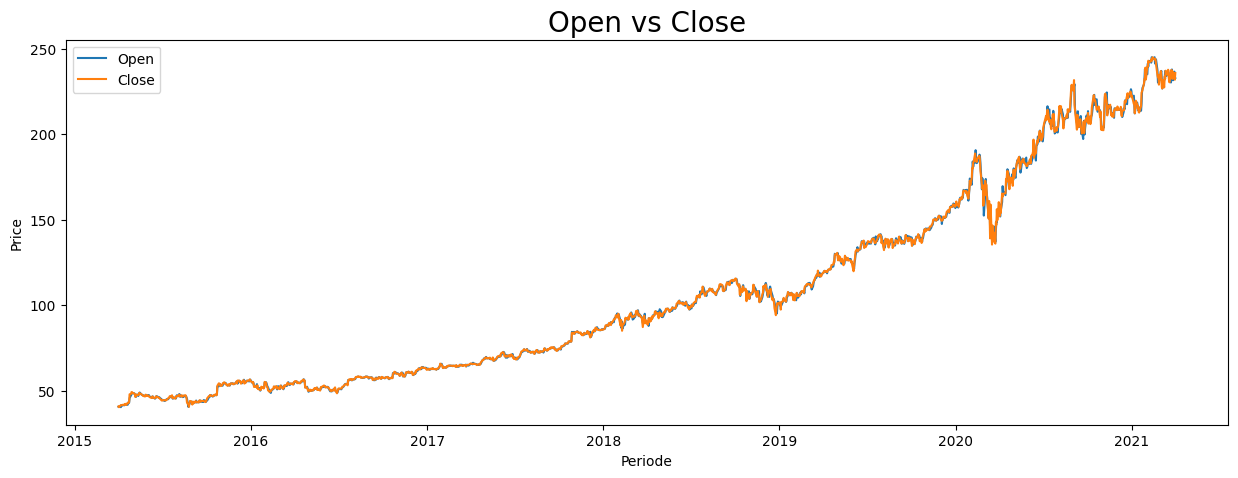

In [4]:
dates = df['Date'].values
close_session  = df['Close'].values
open_session = df['Open'].values
 
plt.figure(figsize=(15,5))
plt.plot(dates, open_session)
plt.plot(dates, close_session)

# info data
plt.title('Open vs Close',
          fontsize=20)
plt.ylabel('Price')
plt.xlabel('Periode')
plt.legend(['Open', 'Close'], loc='upper left')

In [6]:
threshold_mae = (df['Close'].max() - df['Close'].min()) * 10/100
print(threshold_mae)

20.470000000000002


In [7]:
# implement min max scaler 
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()
min_max_scaler.fit(close_session.reshape(-1,1))
close_session = min_max_scaler.transform(close_session.reshape(-1,1))

In [13]:
threshold_mae = (close_session.max() - close_session.min()) * 10/100
print(threshold_mae)

0.9999999999999999


In [9]:
# since open and close are same, we will use close only
# split data validation into 20%
# Calculate the index where the last 20% starts
validation_start_idx = int(len(dates) * 0.8)

# Split the data into training and validation sets
X_train, X_validation = dates[:validation_start_idx], dates[validation_start_idx:]
y_train, y_validation = close_session[:validation_start_idx], close_session[validation_start_idx:]
print('X_train shape:', X_train.shape)
print('X_validation shape:', X_validation.shape)
print('y_train shape:', y_train.shape)
print('y_validation shape:', y_validation.shape)


X_train shape: (1208,)
X_validation shape: (303,)
y_train shape: (1208, 1)
y_validation shape: (303, 1)


In [10]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [11]:
# Create windowed datasets for training and validation
train_dataset = windowed_dataset(y_train, window_size=60, batch_size=100, shuffle_buffer=1000)
validation_dataset = windowed_dataset(y_validation, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=5, activation='relu', input_shape=(60, 1)),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Define the optimizer with a learning rate of 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

# Compile the model
model.compile(loss=tf.keras.losses.Huber(), 
              optimizer=optimizer,
              metrics=["mae"])

In [12]:
num_epochs = 100

# Train the model
history = model.fit(train_dataset, epochs=num_epochs, batch_size=64,validation_data=validation_dataset,verbose=1)

Epoch 1/100
12/12 [==============================] - 5s 163ms/step - loss: 0.0326 - mae: 0.2026 - val_loss: 0.2844 - val_mae: 0.7486
Epoch 2/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0282 - mae: 0.1825 - val_loss: 0.2458 - val_mae: 0.6941
Epoch 3/100
12/12 [==============================] - 0s 27ms/step - loss: 0.0236 - mae: 0.1632 - val_loss: 0.1999 - val_mae: 0.6258
Epoch 4/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0191 - mae: 0.1477 - val_loss: 0.1455 - val_mae: 0.5316
Epoch 5/100
12/12 [==============================] - 0s 26ms/step - loss: 0.0155 - mae: 0.1388 - val_loss: 0.0931 - val_mae: 0.4220
Epoch 6/100
12/12 [==============================] - 0s 28ms/step - loss: 0.0143 - mae: 0.1394 - val_loss: 0.0751 - val_mae: 0.3757
Epoch 7/100
12/12 [==============================] - 0s 25ms/step - loss: 0.0139 - mae: 0.1396 - val_loss: 0.0913 - val_mae: 0.4158
Epoch 8/100
12/12 [==============================] - 0s 27ms/step - loss: 0

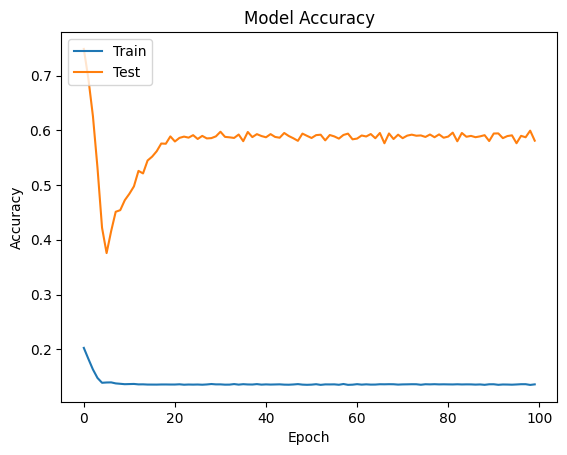

In [15]:
# plot history train
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])

# create info plot
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

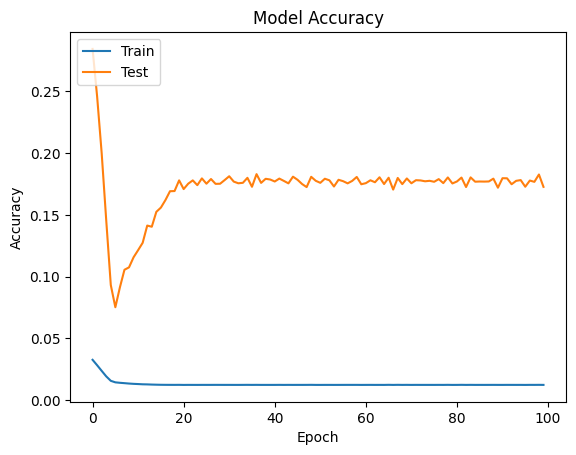

In [16]:
# plot history train
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# create info plot
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')